In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("basukallapur/dog-cat-and-panda-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dog-cat-and-panda-dataset


In [17]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import torchvision.models as models

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [11]:
train_dir = '/root/.cache/kagglehub/datasets/basukallapur/dog-cat-and-panda-dataset/versions/1/autoyos-data/train'
test_dir = '/root/.cache/kagglehub/datasets/basukallapur/dog-cat-and-panda-dataset/versions/1/autoyos-data/test'

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes

In [14]:
len(train_dataset)

1957

In [15]:
len(test_dataset)

893

In [12]:
class_names

['cat', 'dog', 'panda']

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 128),  # Adjusted for 128x128 input size
            nn.ReLU(),
            nn.Linear(128, 3)  # 3 output classes
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x


In [18]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3 classes: dog, cat, panda
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [22]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_loss, train_acc, val_acc = [], [], []
epochs = 50
patience = 5
best_val_acc = 0
counter = 0
early_stop = False

for epoch in range(epochs):
    if early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_train_acc = correct / total
    train_loss.append(epoch_loss)
    train_acc.append(epoch_train_acc)

    # Validation accuracy
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader: # Use test_loader for validation
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_acc = val_correct / val_total
    val_acc.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f}")

    # Early stopping check
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            early_stop = True

Epoch [1/50], Loss: 0.8775, Train Acc: 0.5687, Val Acc: 0.6025
Epoch [2/50], Loss: 0.7040, Train Acc: 0.6704, Val Acc: 0.6394
Epoch [3/50], Loss: 0.6203, Train Acc: 0.7184, Val Acc: 0.6697
Epoch [4/50], Loss: 0.5605, Train Acc: 0.7609, Val Acc: 0.6551
Epoch [5/50], Loss: 0.5373, Train Acc: 0.7547, Val Acc: 0.6797
Epoch [6/50], Loss: 0.4466, Train Acc: 0.8140, Val Acc: 0.6775
Epoch [7/50], Loss: 0.4034, Train Acc: 0.8396, Val Acc: 0.6775
Epoch [8/50], Loss: 0.3884, Train Acc: 0.8421, Val Acc: 0.6988
Epoch [9/50], Loss: 0.3228, Train Acc: 0.8835, Val Acc: 0.6988
Epoch [10/50], Loss: 0.2871, Train Acc: 0.9080, Val Acc: 0.6730
Epoch [11/50], Loss: 0.2937, Train Acc: 0.8835, Val Acc: 0.6797
Epoch [12/50], Loss: 0.2199, Train Acc: 0.9448, Val Acc: 0.6920
Epoch [13/50], Loss: 0.1840, Train Acc: 0.9550, Val Acc: 0.6529
Early stopping at epoch 14


In [25]:
model.load_state_dict(best_model_state)


<All keys matched successfully>

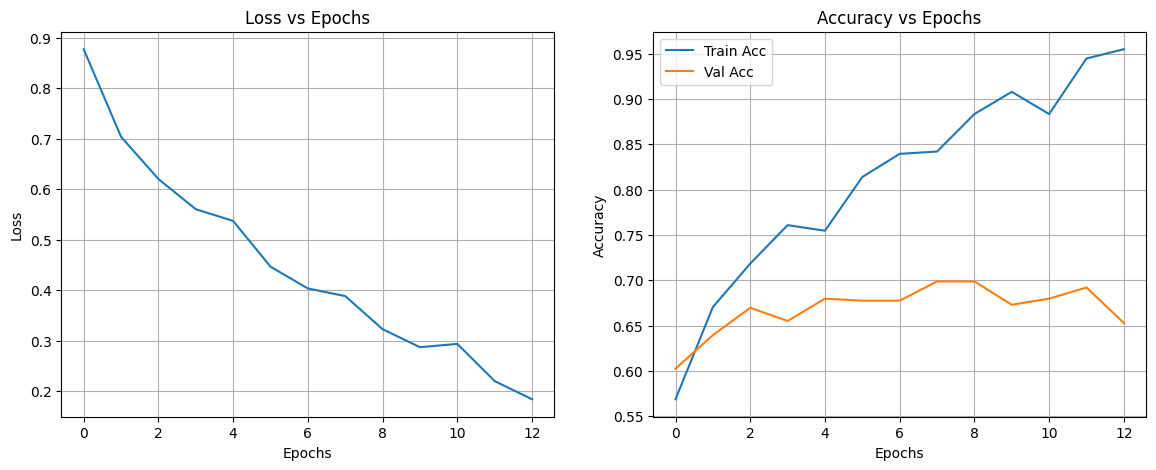

In [26]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 65.29%


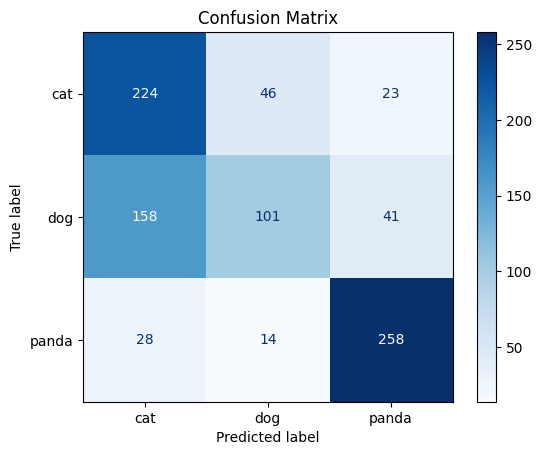

Classification Report:
              precision    recall  f1-score   support

         cat       0.55      0.76      0.64       293
         dog       0.63      0.34      0.44       300
       panda       0.80      0.86      0.83       300

    accuracy                           0.65       893
   macro avg       0.66      0.65      0.64       893
weighted avg       0.66      0.65      0.63       893



In [28]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))



In [29]:
def imshow(img, label, pred):
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = img * 0.5 + 0.5
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[label]}, Pred: {class_names[pred]}")
    plt.axis('off')
    plt.show()


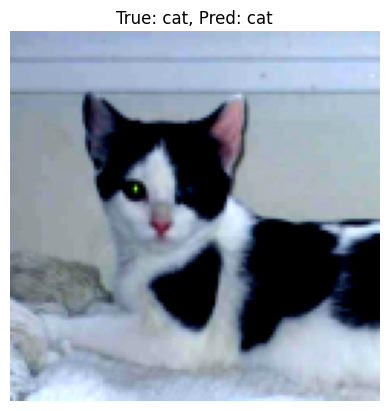

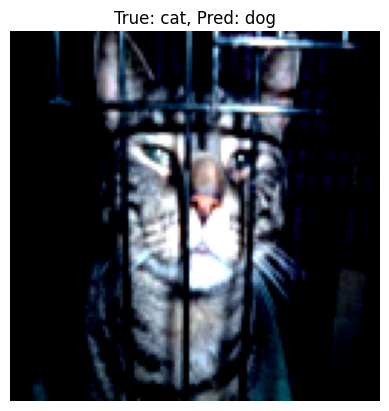

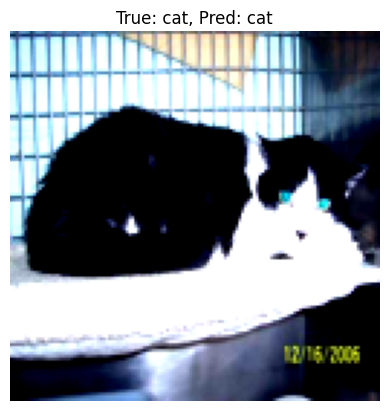

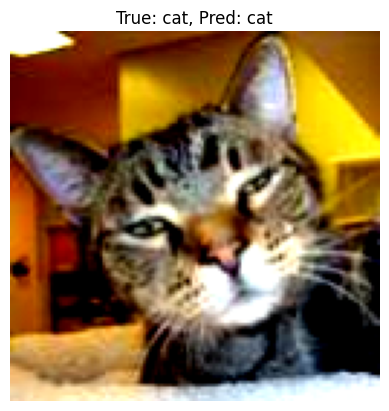

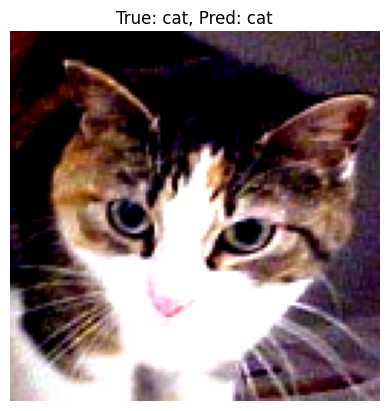

In [30]:
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

for i in range(5):
    imshow(images[i], labels[i].item(), preds[i].item())
